## Visualize results of the linear model

1. LM for all features
2. Group features by channel
3. Coefficient plots

## Import libraries

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Set paths and variables

In [2]:
# Focusing on plate 4
plate <- "localhost231120090001"

# Set directories
input_dir <- "results"
output_fig_dir <- "figures"

# Path to file with LM coefficients to plot
lm_file <- file.path(input_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment.tsv"))

# Paths for each figure output
lm_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment.png"))
lm_group_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_bygroup.png"))
lm_coef_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_coefficients.png"))


## Clean and sort the data prior to plotting

In [3]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

print(dim(lm_df))
head(lm_df, 3)


[1] 667   5


feature,r2_score,cell_count_coef,failing_coef,healthy_coef
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_AreaShape_Compactness,0.014050889,0.001533793,0.03444151,-0.03444151
Cytoplasm_AreaShape_Extent,0.009506222,-0.001073776,0.06792423,-0.06792423
Cytoplasm_AreaShape_FormFactor,0.015722939,-0.001692418,0.01099227,-0.01099227


In [4]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(failing_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

lm_df$channel_cleaned <- dplyr::recode(lm_df$channel_cleaned,
    "Hoechst" = "Nucleus",
    "ER" = "ER",
    "Actin" = "Actin",
    "Mitochondria" = "Mito",
    "PM" = "PM",
    .default = "other",
    .missing = "other"
)

print(dim(lm_df))
head(lm_df, 3)


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 451 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, ...].”


[1] 667  13


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_count_coef,failing_coef,healthy_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Intensity_IntegratedIntensity_Actin,Cells,Intensity,IntegratedIntensity,Actin,NA,NA,NA,0.08172668,-0.0024722578,0.4958244,-0.4958244,Actin
Nuclei_Correlation_K_ER_Actin,Nuclei,Correlation,K,ER,Actin,NA,NA,0.09505860,-0.0009093331,0.4679124,-0.4679124,ER
Nuclei_Granularity_1_PM,Nuclei,Granularity,1,PM,NA,NA,NA,0.13873445,0.0007098423,0.4538414,-0.4538414,PM


## Visualize linear modeling results

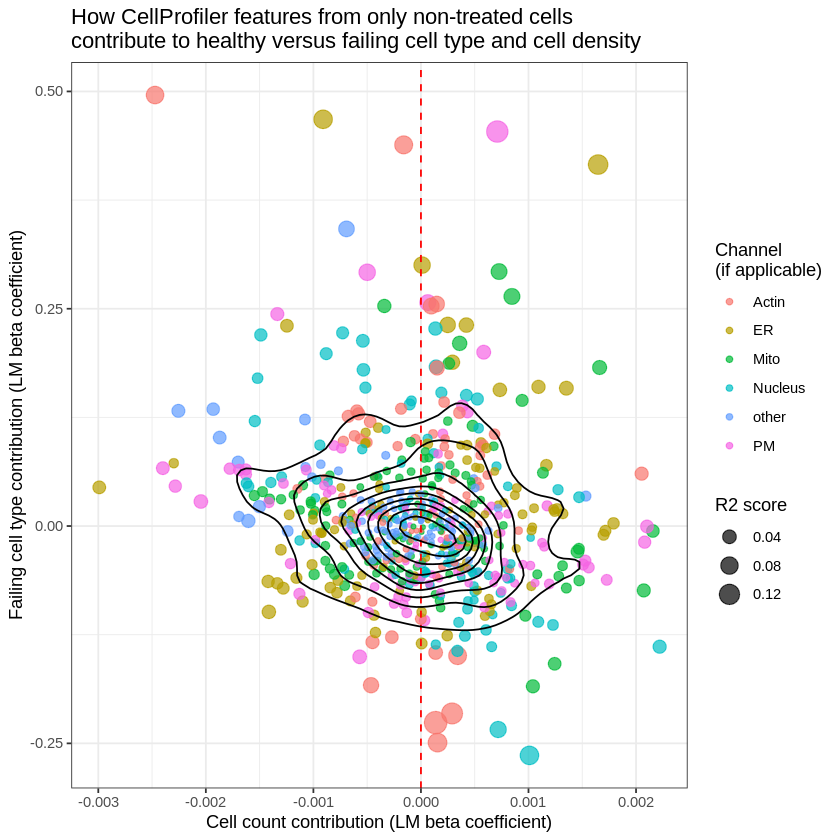

In [9]:
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = failing_coef))
    + geom_point(aes(size = r2_score, color = channel_cleaned), alpha = 0.7)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_density2d(color="black", show.legend = FALSE)
    + theme_bw()
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing cell type contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features from only non-treated cells\ncontribute to healthy versus failing cell type and cell density")
)

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

lm_fig_gg


## Visualize LM based on channel

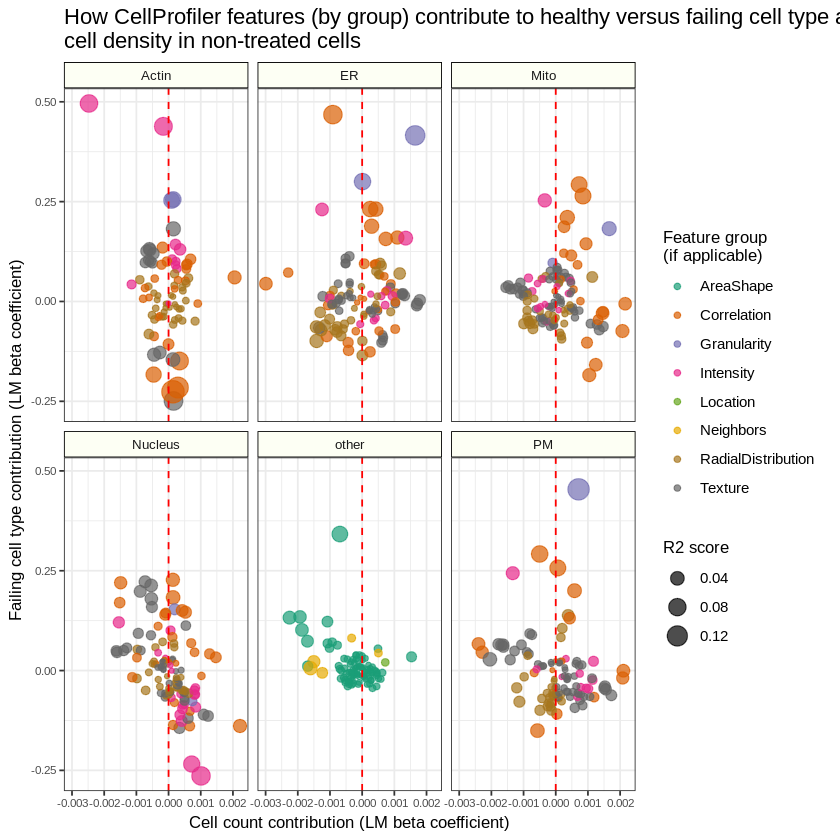

In [6]:
lm_group_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = failing_coef))
    + geom_point(aes(size = r2_score, color = feature_group), alpha = 0.7)
    + facet_wrap("~channel_cleaned")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + theme_bw()
    + guides(
        color = guide_legend(title = "Feature group\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing cell type contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features (by group) contribute to healthy versus failing cell type and\ncell density in non-treated cells")
    + scale_color_brewer(palette="Dark2")
    + theme(
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_group_fig, lm_group_fig_gg, height = 6, width = 10, dpi = 500)

lm_group_fig_gg


## Visualize coefficients per LM

In [7]:
channels <- c(
    "Mitochondria" = "Mito",
    "Hoechst" = "DNA",
    "PM" = "PM",
    "ER" = "ER",
    "Actin" = "Actin"
)

lm_cleaned_df <- lm_df %>%
    dplyr::filter(channel %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = failing_coef, n = 1)

head(lm_cleaned_df, 2)


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_count_coef,failing_coef,healthy_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Correlation_Correlation_Actin_Hoechst,Cells,Correlation,Correlation,Actin,Hoechst,NA,NA,0.004122527,-0.0007312714,0.03364341,-0.03364341,Actin
Cytoplasm_Correlation_RWC_Actin_PM,Cytoplasm,Correlation,RWC,Actin,PM,NA,NA,0.008414373,0.0005516654,0.08135566,-0.08135566,Actin


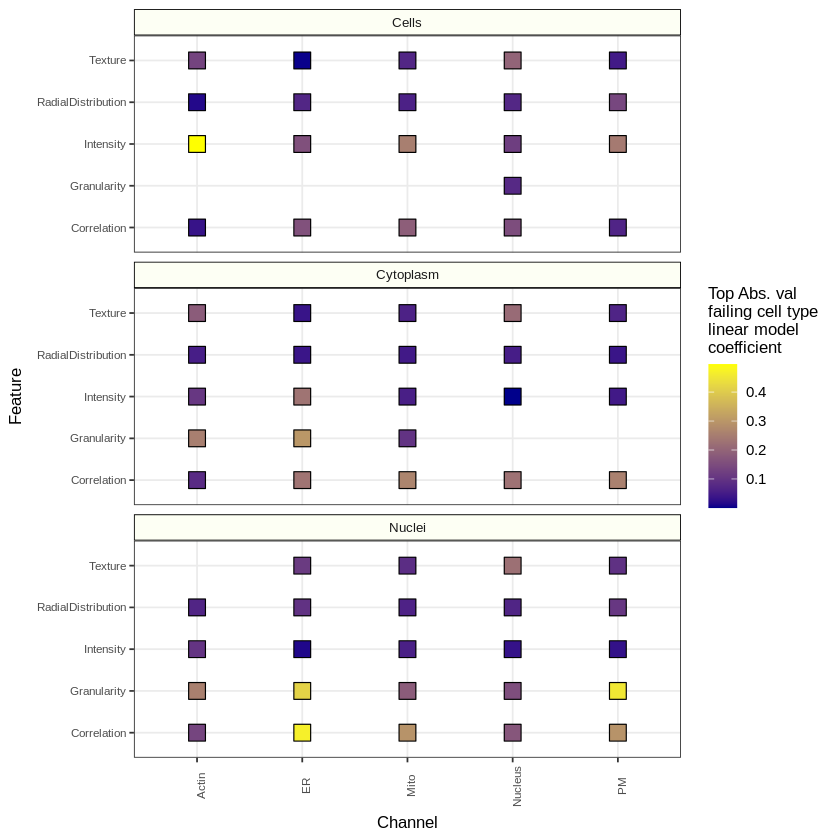

In [8]:
coef_gg <- (
    ggplot(lm_cleaned_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = abs(failing_coef)), pch = 22, size = 5)
    + facet_wrap("~compartment", ncol = 1)
    + theme_bw()
    + scale_fill_gradient(
        name="Top Abs. val\nfailing cell type\nlinear model\ncoefficient",
        low = "darkblue",
        high = "yellow"
    )
    + xlab("Channel")
    + ylab("Feature")
    + theme(
        axis.text = element_text(size = 7),
        axis.text.x = element_text(angle = 90, size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_coef_fig, coef_gg, height = 5, width = 3.5, dpi = 500)

coef_gg
